# Tests for covariance of lognormal fields

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  helpers_plot import initPlot
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.stats
from scipy.optimize import curve_fit
from os.path import exists
from astropy.io import fits

In [2]:
initPlot()
dir_ms="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/MS/"
dir_slics="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS/"

In [3]:
# Set Thetas labels
thetas_ind = np.array([[2, 2, 2], [2, 2, 4], [2, 2, 8], [2, 2, 16],
                       [2, 4, 4], [2, 4, 8], [2, 4, 16], [2, 8, 8],
                       [2, 8, 16], [2, 16, 16], [4, 4, 4], [4, 4, 8],
                       [4, 4, 16], [4, 8, 8], [4, 8, 16], [4, 16, 16],
                       [8, 8, 8], [8, 8, 16], [8, 16, 16], [16, 16, 16]])
thetas_labels = []
for thetas in thetas_ind:
    thetas_labels.append(f"{thetas[0]}' {thetas[1]}' {thetas[2]}'")
N = len(thetas_ind)
thetas_ticks = np.arange(0, N)
cmap1=cm.get_cmap('viridis', 14)
cmap2=cm.get_cmap('RdBu', 16)

In [4]:
# Get independent thetas
N = 4 # Number of aperture radii
Nlos=128
Nlos2=256
Nlos_ms=64
ixs = []
for i in range(N):
    for j in range(i, N):
        for k in range(j, N):
            ix = i*N**2+j*N+k
            ixs.append(ix)

## Comparisons with Millennium Simulation

### Getting the PDF of the Millennium Simulation

In [20]:
# Loading data of one LOS
mean_kappa=[]
std_kappa=[]
skew_kappa=[]
bins=200
Nlos=64
pdf_kappa=np.zeros((Nlos, bins))
kappa_min, kappa_max=-0.2, 0.2

for los in range(Nlos):
    los_no1 = los//8
    los_no2 = los%8

    fn="/41_los_8_"+ str(los_no1) +"_"+ str(los_no2) +".ascii"
    print("Loading", fn)
    kappa=np.loadtxt(dir_ms+fn).reshape(4096, 4096, 5)[:,:,4]
    print("kappa mean:", np.mean(kappa))
    mean_kappa.append(np.mean(kappa))
    print("kappa std:", np.std(kappa))
    std_kappa.append(np.std(kappa))
    print("kappa skew:", scipy.stats.skew(kappa, axis=None))
    skew_kappa.append(scipy.stats.skew(kappa, axis=None))
    pdf, _tmp=(np.histogram(kappa, bins=bins, density=False, range=(kappa_min, kappa_max)))
    
    pdf_kappa[los]=pdf
   


np.save("MS_mean_kappa", mean_kappa)
np.save("MS_std_kappa", std_kappa)
np.save("MS_skew_kappa", skew_kappa)
np.save("MS_pdf_kappa", pdf_kappa)

Loading /41_los_8_0_0.ascii
kappa mean: -0.0029918169912690204
kappa std: 0.023285717112117847
kappa skew: 5.007614599856214
Loading /41_los_8_0_1.ascii
kappa mean: -0.002071169107380672
kappa std: 0.024165900040073254
kappa skew: 5.040693629065347
Loading /41_los_8_0_2.ascii
kappa mean: 0.0011209463395987652
kappa std: 0.02647304631375774
kappa skew: 5.416403110637103
Loading /41_los_8_0_3.ascii
kappa mean: 0.004022999708888764
kappa std: 0.0281958724707134
kappa skew: 5.372298674409562
Loading /41_los_8_0_4.ascii
kappa mean: -0.0028977296820228006
kappa std: 0.023177614111047542
kappa skew: 5.129456830924317
Loading /41_los_8_0_5.ascii
kappa mean: -0.0005564271373480723
kappa std: 0.024573648311501568
kappa skew: 4.895511148523915
Loading /41_los_8_0_6.ascii
kappa mean: 0.00012781966583545547
kappa std: 0.025612351231677082
kappa skew: 5.084374265253126
Loading /41_los_8_0_7.ascii
kappa mean: -0.0022983856839972673
kappa std: 0.02414156082137538
kappa skew: 5.579606268863387
Loading 

In [8]:
# Functions for PDF

def lognormal(xs, kappa0, alpha):
    """Lognormal according to Eq. 22 in Hilbert+2011. Alpha is the same as the sigma in Hilbert+11
    """

    
    ps=np.zeros_like(xs)

    for i, x in enumerate(xs):
        if(x>-kappa0):
            p=np.log(x/kappa0+1)+0.5*alpha*alpha
            p=-0.5*p*p/alpha/alpha
            p=np.exp(p)/np.sqrt(2*np.pi)/(x+kappa0)/alpha
            ps[i]=p
    return ps


def gauss(x, sigma):
    p=-x*x/2/sigma/sigma
    p=np.exp(p)/np.sqrt(2*np.pi)/sigma
    return p

def alpha2skew(alpha):
    result=np.exp(alpha*alpha)+2
    result*=np.sqrt(np.exp(alpha*alpha)-1)
    return result

def skew2alpha(skew):
    result=np.sqrt(np.log(0.793701*np.power(skew**2 + np.sqrt(skew**4 + 4*skew**2) + 2, 1/3) + 1.25992/np.power(skew**2 + np.sqrt(skew**4 + 4*skew**2) + 2, 1/3) - 1))
    return result

def kappa0_alpha2std(kappa0, alpha):
    result=kappa0*np.sqrt(np.exp(alpha*alpha)-1)
    return result

def alpha_std2kappa0(alpha, std):
    result=std/np.sqrt(np.exp(alpha*alpha)-1)
    return result

In [10]:
# Get Mean
pdf_kappa=np.load("MS_pdf_kappa.npy")
kappa_min, kappa_max=-0.2, 0.2
bins=200

pdf_xrange=np.linspace(kappa_min, kappa_max, num=bins)
pdf_kappa_mean=np.mean(pdf_kappa, axis=0)
pdf_kappa_std=np.std(pdf_kappa, axis=0)
norm=np.sum(pdf_kappa_mean)*(kappa_max-kappa_min)/bins

In [11]:
# Fit

xdata=pdf_xrange[82:]
ydata=pdf_kappa_mean[82:]/norm
sigma=pdf_kappa_std[82:]/norm

popt, pcov=curve_fit(lognormal, xdata, ydata, sigma=sigma, absolute_sigma=True, p0=(0.022, 0.66))#, absolute_sigma=False)
popt2, pcov=curve_fit(lognormal, xdata, ydata, p0=(0.022, 0.66))#, absolute_sigma=False)


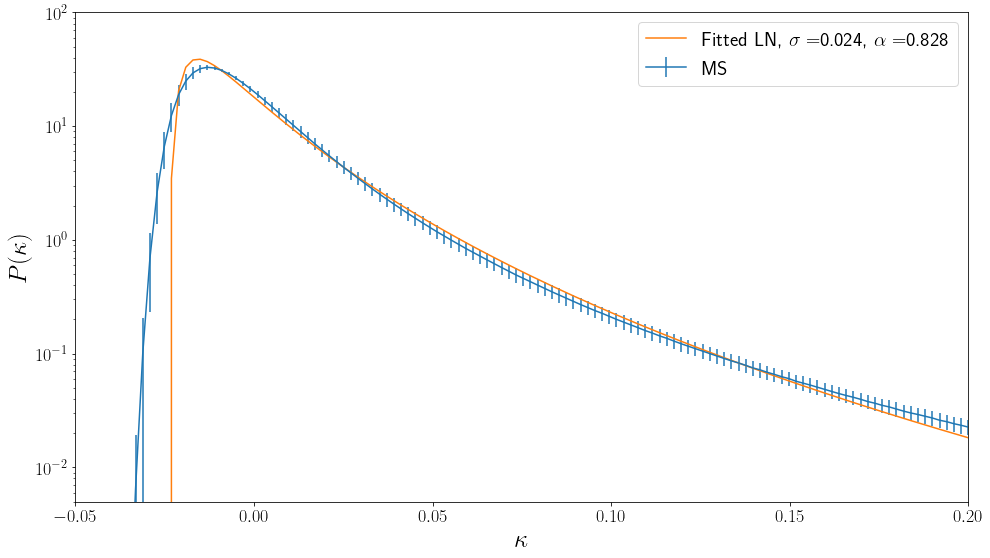

In [22]:
# Get the parameters of the pdfs

# MS_mean=np.mean(mean_kappa)
# MS_std=np.mean(std_kappa)
# MS_skew=np.mean(skew_kappa)
# MS_alpha=skew2alpha(MS_skew)
# MS_kappa0=alpha_std2kappa0(MS_alpha, MS_std)

# Hilbert_mean=0
# Hilbert_alpha=0.66
# Hilbert_skew=alpha2skew(Hilbert_alpha)
# Hilbert_kappa0=0.0291
# Hilbert_std=kappa0_alpha2std(Hilbert_kappa0, Hilbert_alpha)

fit_mean=0
fit_alpha=popt[1]
fit_skew=alpha2skew(fit_alpha)
fit_kappa0=popt[0]
fit_std=kappa0_alpha2std(fit_kappa0, fit_alpha)

# fit_mean_unweighted=0
# fit_alpha_unweighted=popt2[1]
# fit_skew_unweighted=alpha2skew(fit_alpha_unweighted)
# fit_kappa0_unweighted=popt2[0]
# fit_std_unweighted=kappa0_alpha2std(fit_kappa0_unweighted, fit_alpha_unweighted)

# Do the plots
fig, ax=plt.subplots(figsize=(16,9), nrows=1)
#fig.suptitle(r"$\kappa$-PDF in MS")
# ax[0].set_xlim((-0.05, 0.2))
# ax[0].errorbar(pdf_xrange, pdf_kappa_mean/norm, yerr=pdf_kappa_std/norm, label=f'MS, all LOS, mean:{MS_mean:.3f}, std:{MS_std:.3f}, skew: {MS_skew:.3f}, alpha: {MS_alpha:.3f}', ls='--')
# ax[0].plot(pdf_xrange, lognormal(pdf_xrange, MS_kappa0, MS_alpha), label=f'LN from MS moments, mean:{MS_mean:.2f}, std:{MS_std:.3f}, skew: {MS_skew:.3f}, alpha: {MS_alpha:.3f}')
# ax[0].plot(pdf_xrange, lognormal(pdf_xrange, Hilbert_kappa0, Hilbert_alpha), label=f'LN from Hilbert+ (2011), mean:{Hilbert_mean:.3f}, std:{Hilbert_std:.3f}, skew: {Hilbert_skew:.3f}, alpha: {Hilbert_alpha:.3f}')
# ax[0].plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0, fit_alpha), label=f'LN from Fit, mean:{fit_mean:.3f}, std:{fit_std:.3f}, skew: {fit_skew:.3f}, alpha: {fit_alpha:.3f}')
# ax[0].plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0_unweighted, fit_alpha_unweighted), label=f'LN from Fit without uncertainties, mean:{fit_mean_unweighted:.3f}, std:{fit_std_unweighted:.3f}, skew: {fit_skew_unweighted:.3f}, alpha: {fit_alpha_unweighted:.3f}')
# ax[0].legend()

ax.set_xlim((-0.05, 0.2))
ax.set_yscale('log')
ax.set_ylim((5e-3, 1e2))
ax.errorbar(pdf_xrange, pdf_kappa_mean/norm, yerr=pdf_kappa_std/norm, label=f'MS')#, all LOS, mean:{MS_mean:.3f}, std:{MS_std:.3f}, skew: {MS_skew:.3f}, alpha: {MS_alpha:.3f}', ls='--')
#ax.plot(pdf_xrange, lognormal(pdf_xrange, MS_kappa0, MS_alpha), label=f'LN from MS moments, mean:{MS_mean:.2f}, std:{MS_std:.3f}, skew: {MS_skew:.3f}, alpha: {MS_alpha:.3f}')
#ax.plot(pdf_xrange, lognormal(pdf_xrange, Hilbert_kappa0, Hilbert_alpha), label=f'LN from Hilbert+ (2011), mean:{Hilbert_mean:.3f}, std:{Hilbert_std:.3f}, skew: {Hilbert_skew:.3f}, alpha: {Hilbert_alpha:.3f}')
ax.plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0, fit_alpha), label=r"Fitted LN, $\sigma=$"+f"{fit_std:.3f}"+r", $\alpha=$"+f"{fit_alpha:.3f}")
#ax.plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0_unweighted, fit_alpha_unweighted), label=f'LN from Fit without uncertainties, mean:{fit_mean_unweighted:.3f}, std:{fit_std_unweighted:.3f}, skew: {fit_skew_unweighted:.3f}, alpha: {fit_alpha_unweighted:.3f}')
ax.legend(fontsize=20)
ax.set_xlabel(r'$\kappa$', fontsize=25)
ax.set_ylabel(r'$P(\kappa)$', fontsize=25)
plt.savefig("PDF_MS_Kappa.pdf")

### Millennium-like lognormal fields

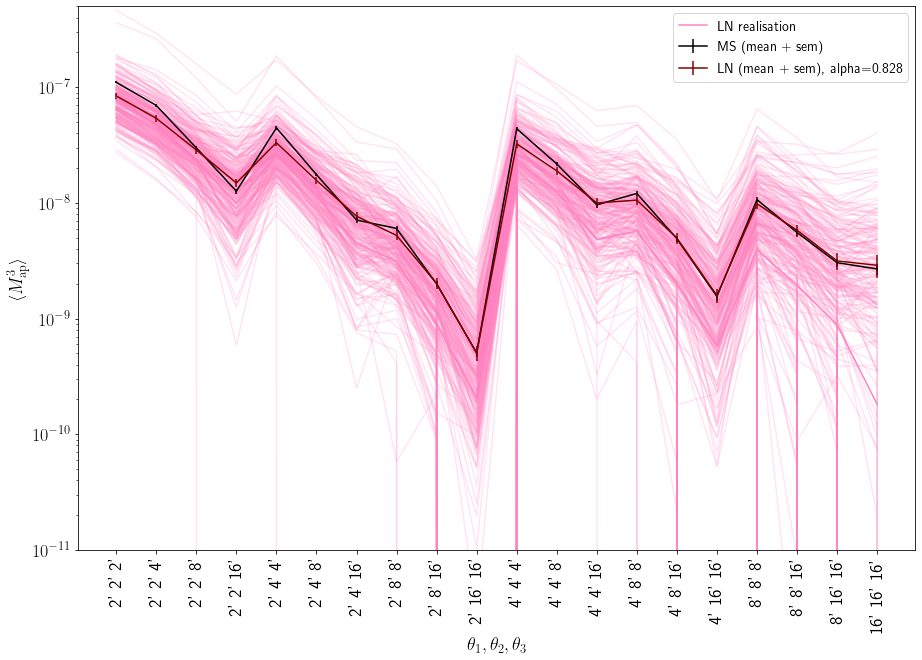

In [5]:
# Read in Map3 from ln fields
dir_msln="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/LognormalFields_MSlike_alpha_0_828/"
Map3ln=np.load(dir_msln+"map_cubed_from_gamma_npix_4096_fieldsize_4.npy")

dir_mslncut="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/LognormalFields_MSlike_alpha_0_828_cutOutFromBiggerField/"
Map3lncut=np.load(dir_mslncut+"map_cubed_from_gamma_npix_4096_fieldsize_4.npy")

# Read in Map3 from gaussian fields
dir_msgauss="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/GaussianRandomFields_MSlike/"
Map3gauss=np.load(dir_msgauss+"map_cubed_from_gamma_npix_4096_fieldsize_4.npy")
 
# Read in Map3 from gaussian fields cut out
dir_msgausscut="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/GaussianRandomFields_MSlike_cutOutFromBiggerField/"
Map3gausscut=np.load(dir_msgauss+"map_cubed_from_gamma_npix_4096_fieldsize_4.npy")

# Read in Map3 from MS
Map3ms=np.loadtxt(dir_ms+"map_cubed").T
Map3ms_mean=np.mean(Map3ms, axis=1)
Map3ms_std=np.std(Map3ms, axis=1)



Map3ln = Map3ln.reshape(N*N*N, 256)
Map3ln = Map3ln[ixs].T

Map3lncut = Map3lncut.reshape(N*N*N, 128)
Map3lncut = Map3lncut[ixs].T

Map3gauss = Map3gauss.reshape(N*N*N, 256)
Map3gauss = Map3gauss[ixs].T

Map3gausscut = Map3gausscut.reshape(N*N*N, 256)
Map3gausscut = Map3gausscut[ixs].T



Map3ln_mean=np.mean(Map3ln, axis=0)
Map3ln_std=np.std(Map3ln, axis=0)
Map3gauss_mean=np.mean(Map3gauss, axis=0)
Map3gauss_std=np.std(Map3gauss, axis=0)
Map3lncut_mean=np.mean(Map3lncut, axis=0)
Map3lncut_std=np.std(Map3lncut, axis=0)

fig, ax=plt.subplots(figsize=(15,10))
ax.set_ylim((1e-11, 5e-7))
ax.set_yscale('log')
ax.set_ylabel(r'$\langle M_\mathrm{ap}^3\rangle$')
ax.set_xticks(thetas_ticks)
ax.set_xticklabels(thetas_labels, rotation=90)
ax.set_xlabel(r"$\theta_1, \theta_2, \theta_3$")
for i,line in enumerate(Map3ln):
    if(i==0):
        ax.plot(line, color='xkcd:pink', alpha=1, label='LN realisation')
    else:
        ax.plot(line, color='xkcd:pink', alpha=0.2, zorder=-32)


ax.errorbar(range(20), Map3ms_mean, yerr=Map3ms_std/np.sqrt(256), color='k', label='MS (mean + sem)')
ax.errorbar(np.arange(20), Map3ln_mean, yerr=Map3ln_std/np.sqrt(64), color='xkcd:dark red', label='LN (mean + sem), alpha=0.828')
#ax.errorbar(np.arange(20), Map3lncut_mean, yerr=Map3lncut_std/np.sqrt(128), color='xkcd:blue', label='LN (mean + std), alpha=0.828, cut Out')
#ax.errorbar(np.arange(20), Map3gauss_mean, yerr=Map3gauss_std, color='xkcd:dark blue', label='Gauss (mean + std)')
plt.legend()


### Comparing the covariances

In [6]:
MScov_fft=np.loadtxt(dir_ms+"cov_MS_fft_sigma_0.00_n_1048576.00_thetaMax_1.87.dat")
MScov_T1inf=np.loadtxt(dir_ms+"cov_infinite_term1Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
MScov_T2=np.loadtxt(dir_ms+"cov_square_term2Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
MScov_T4=np.loadtxt(dir_ms+"cov_infinite_term4Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
MScov_T5=np.loadtxt(dir_ms+"cov_infinite_term5Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
MScov_T6=np.loadtxt(dir_ms+"cov_square_term6Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")
MScov_T7=np.loadtxt(dir_ms+"cov_infinite_term7Numerical_sigma_0.00_n_1048456.68_thetaMax_1.87_gpu.dat")

MScov_LN=np.cov(Map3ln.T)
MScov_Gauss=np.cov(Map3gauss.T)
MScov_LN_cut=np.cov(Map3lncut.T)
MScov_Gauss_cut=np.cov(Map3gausscut.T)

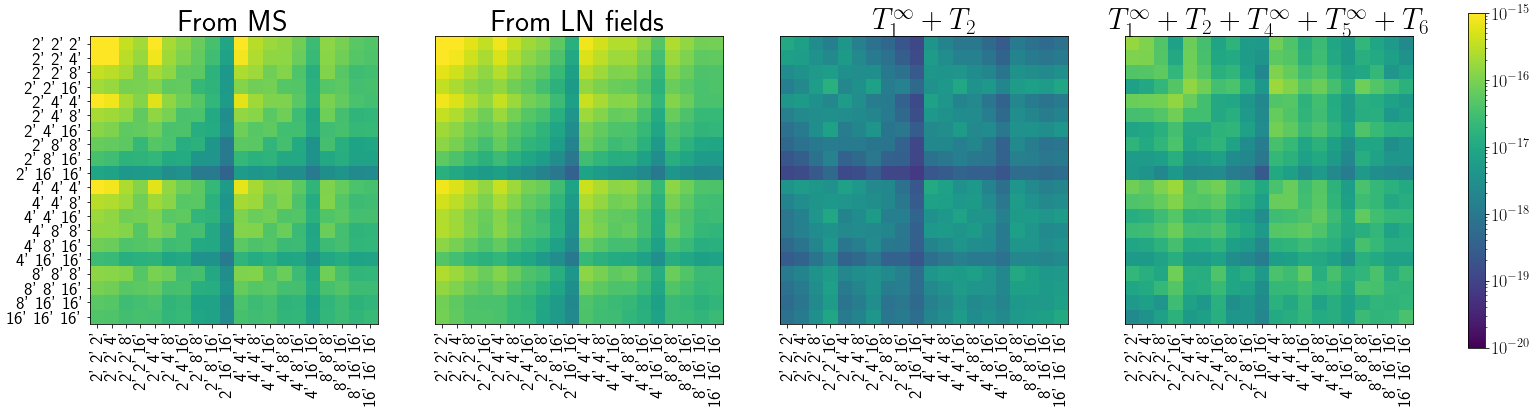

In [7]:
fig, ax=plt.subplots(ncols=4, figsize=(25,10))
#fig.suptitle(r"$\langle M_\mathrm{ap}^3\rangle$-Covariances", y=0.9)

for ax_ in ax:
    ax_.set_xticks(thetas_ticks)

    ax_.set_xticklabels(thetas_labels, rotation=90)
    ax_.set_yticks([])

ax[0].set_yticks(thetas_ticks)
ax[0].set_yticklabels(thetas_labels)


ax[0].set_title("From MS", size=30)
im=ax[0].imshow(MScov_fft, norm=LogNorm(vmin=1e-20, vmax=1e-15))
ax[1].set_title("From LN fields", size=30)
ax[1].imshow(MScov_LN, norm=LogNorm(vmin=1e-20, vmax=1e-15))
ax[2].set_title(r"$T_1^\infty + T_2$", size=30)
ax[2].imshow(MScov_T1inf+MScov_T2, norm=LogNorm(vmin=1e-20, vmax=1e-15))
ax[3].set_title(r"$T_1^\infty + T_2 +T_4^\infty+T_5^\infty+T_6$", size=30)
ax[3].imshow(MScov_T1inf+MScov_T2+MScov_T4+MScov_T5+MScov_T6, norm=LogNorm(vmin=1e-20, vmax=1e-15))

#ax[3].set_title("From GRF")
#ax[3].imshow(MScov_Gauss, norm=LogNorm(vmin=1e-20, vmax=1e-15))
#ax[4].imshow(np.broadcast_to(T6, MScov_LN.shape), norm=LogNorm(vmin=1e-20, vmax=1e-15))
#ax[5].imshow(MScov_LN/30-MScov_T1inf+MScov_T2+MScov_T4+MScov_T5, norm=LogNorm(vmin=1e-20, vmax=1e-15))
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.012, pad=0.04)


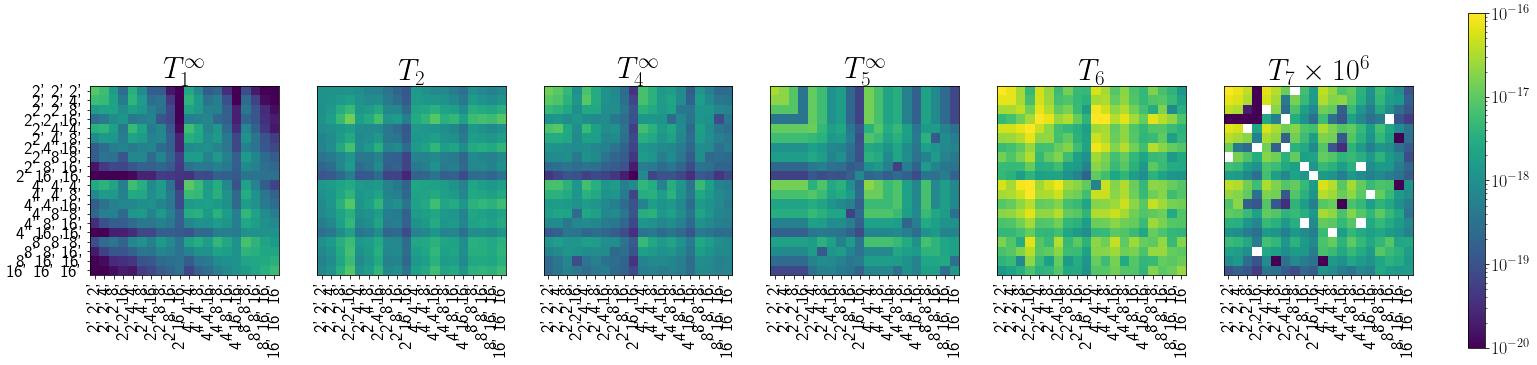

In [8]:
# Individual terms of analytic covariance

fig, ax=plt.subplots(ncols=6, figsize=(25,10))
#fig.suptitle(r"$\langle M_\mathrm{ap}^3\rangle$-Covariances", y=0.9)

for ax_ in ax:
    ax_.set_xticks(thetas_ticks)

    ax_.set_xticklabels(thetas_labels, rotation=90)
    ax_.set_yticks([])

ax[0].set_yticks(thetas_ticks)
ax[0].set_yticklabels(thetas_labels)

m = np.median(MScov_T4[MScov_T4 > 0])
# Assign the median to the zero elements 
MScov_T4[MScov_T4 <= 0] = m

m = np.median(MScov_T4[MScov_T5 > 0])
# Assign the median to the zero elements 
MScov_T5[MScov_T5 <= 0] = m


m = np.median(MScov_T6[MScov_T6 > 0])
# Assign the median to the zero elements 
MScov_T6[MScov_T6 <= 1e-19] = m

ax[0].set_title(r"$T_1^\infty$", size=30)
im=ax[0].imshow(MScov_T1inf, norm=LogNorm(vmin=1e-20, vmax=1e-16))
ax[1].set_title(r"$T_2$", size=30)
im=ax[1].imshow(MScov_T2, norm=LogNorm(vmin=1e-20, vmax=1e-16))
ax[2].set_title(r"$T_4^\infty$", size=30)
im=ax[2].imshow(MScov_T4, norm=LogNorm(vmin=1e-20, vmax=1e-16))
ax[3].set_title(r"$T_5^\infty$", size=30)
im=ax[3].imshow(MScov_T5, norm=LogNorm(vmin=1e-20, vmax=1e-16))
ax[4].set_title(r"$T_6$", size=30)
im=ax[4].imshow(MScov_T6, norm=LogNorm(vmin=1e-20, vmax=1e-16))
ax[5].set_title(r"$T_7 \times 10^6$", size=30)
im=ax[5].imshow(MScov_T7*1e6, norm=LogNorm(vmin=1e-20, vmax=1e-16))

#ax[3].set_title("From GRF")
#ax[3].imshow(MScov_Gauss, norm=LogNorm(vmin=1e-20, vmax=1e-15))
#ax[4].imshow(np.broadcast_to(T6, MScov_LN.shape), norm=LogNorm(vmin=1e-20, vmax=1e-15))
#ax[5].imshow(MScov_LN/30-MScov_T1inf+MScov_T2+MScov_T4+MScov_T5, norm=LogNorm(vmin=1e-20, vmax=1e-15))
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.012, pad=0.04)


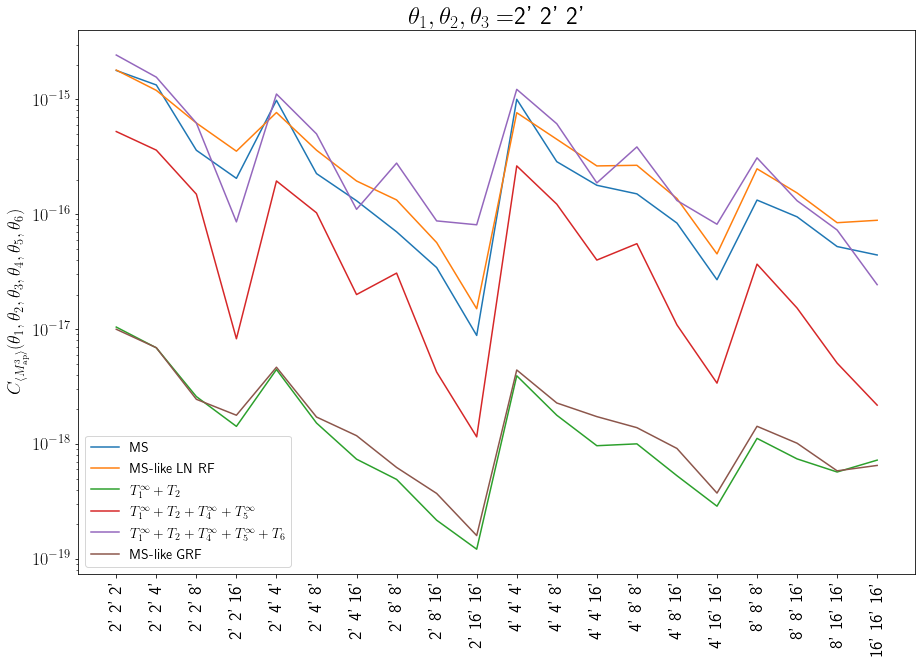

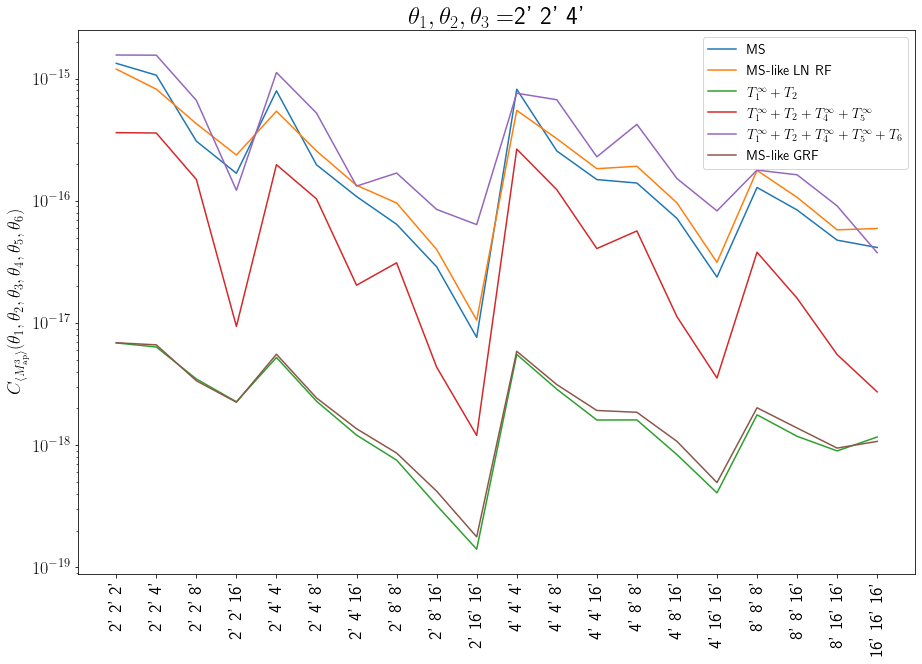

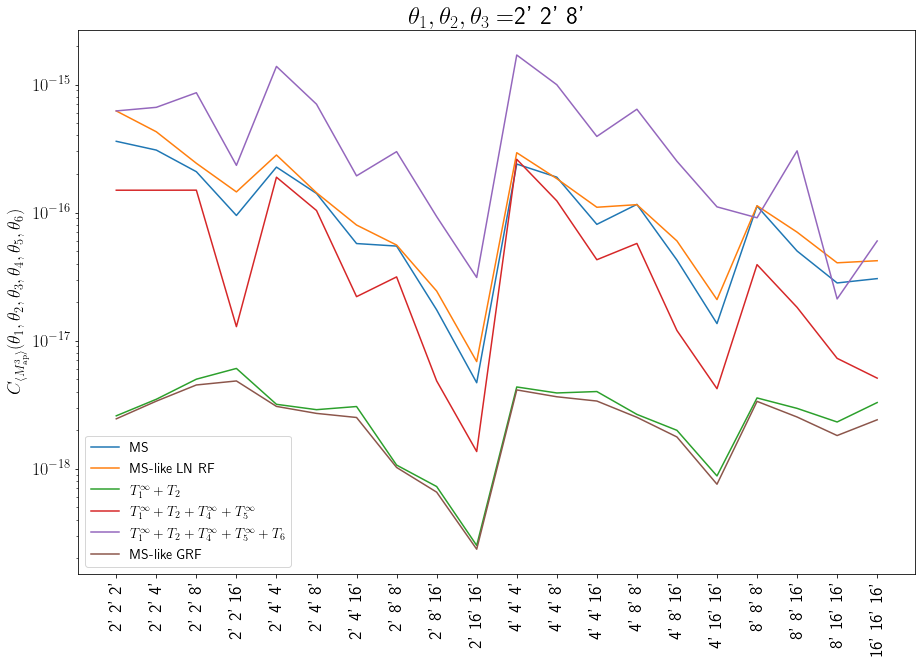

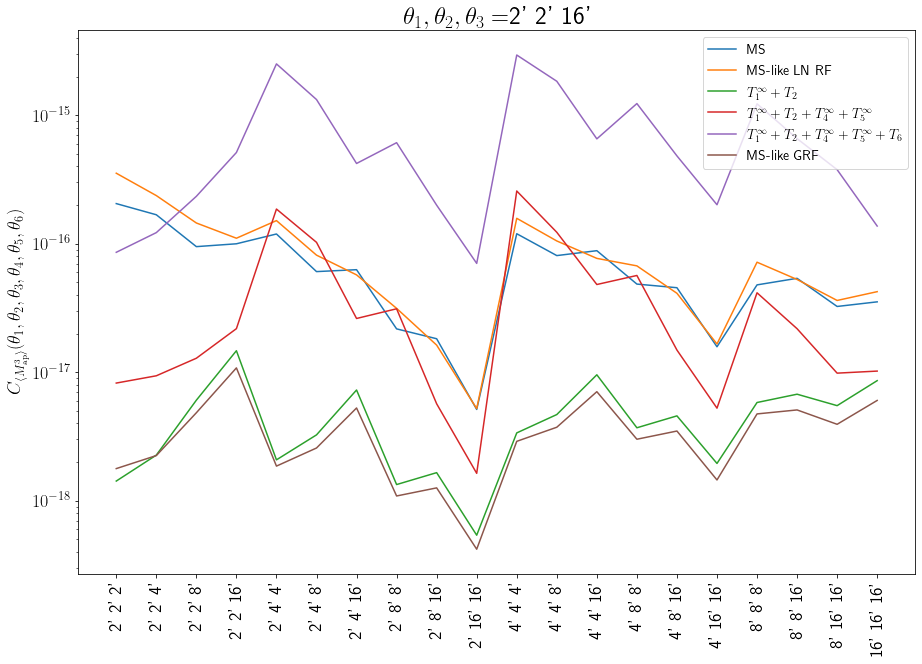

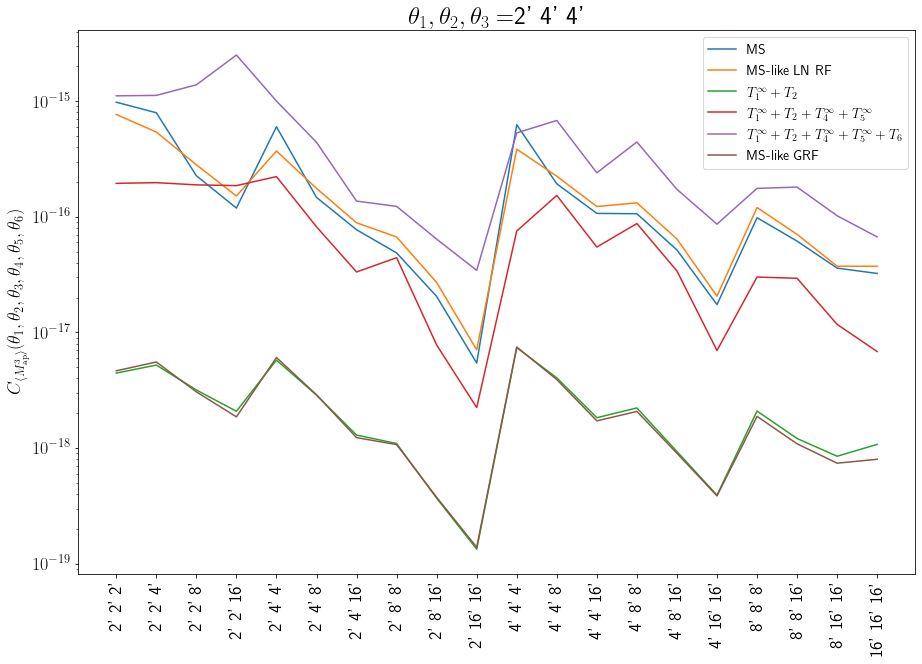

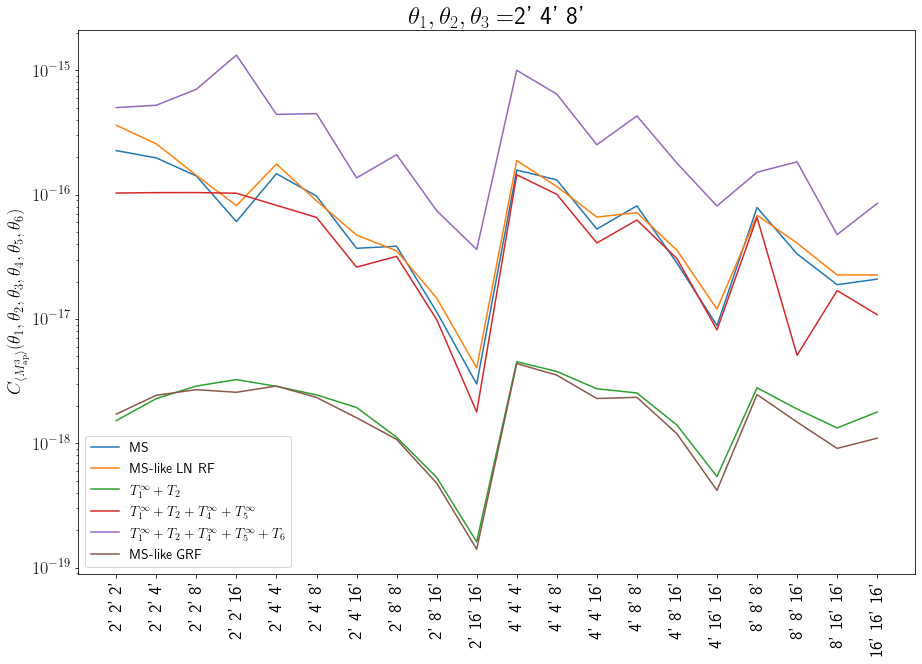

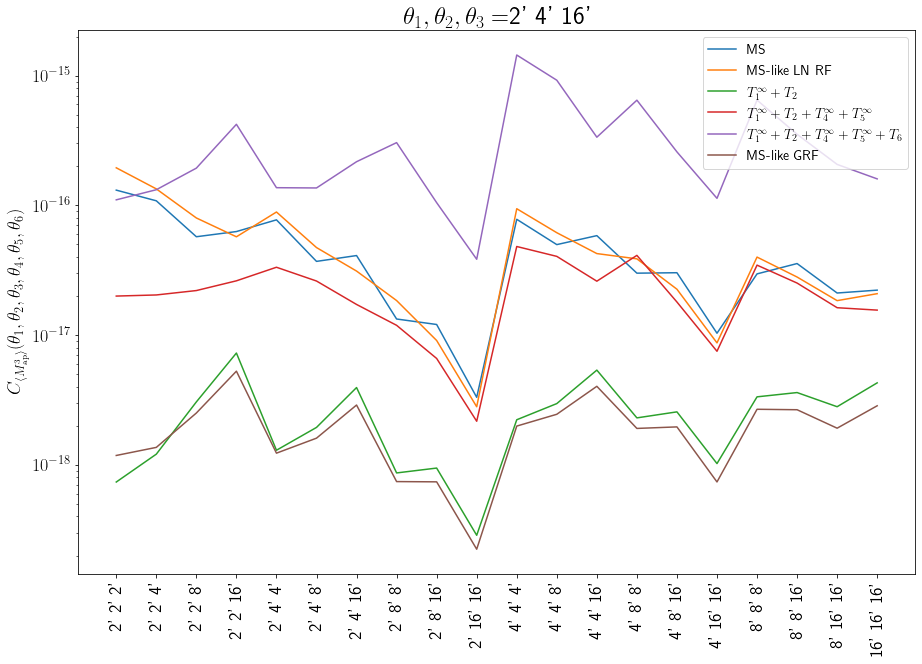

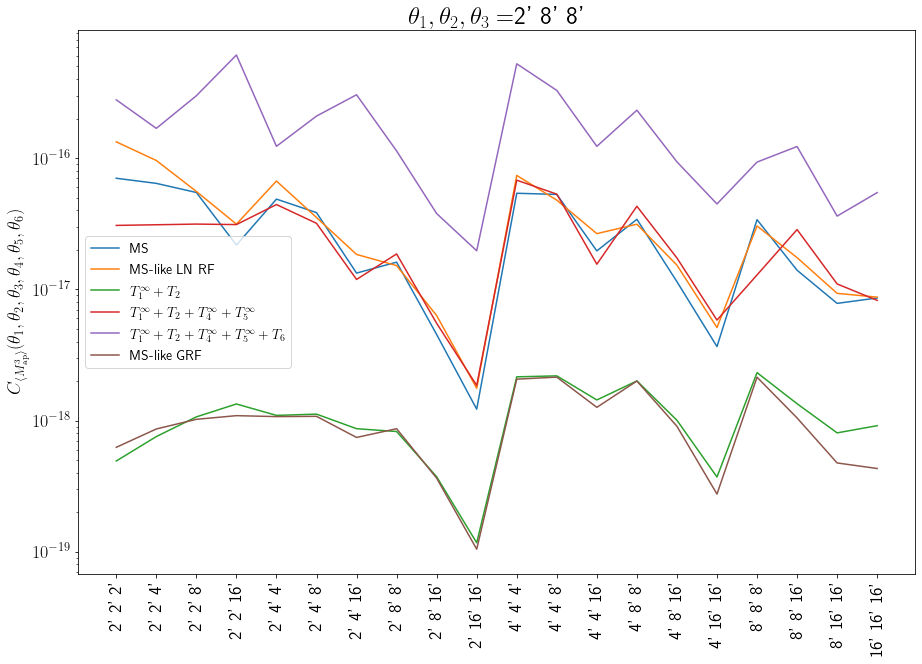

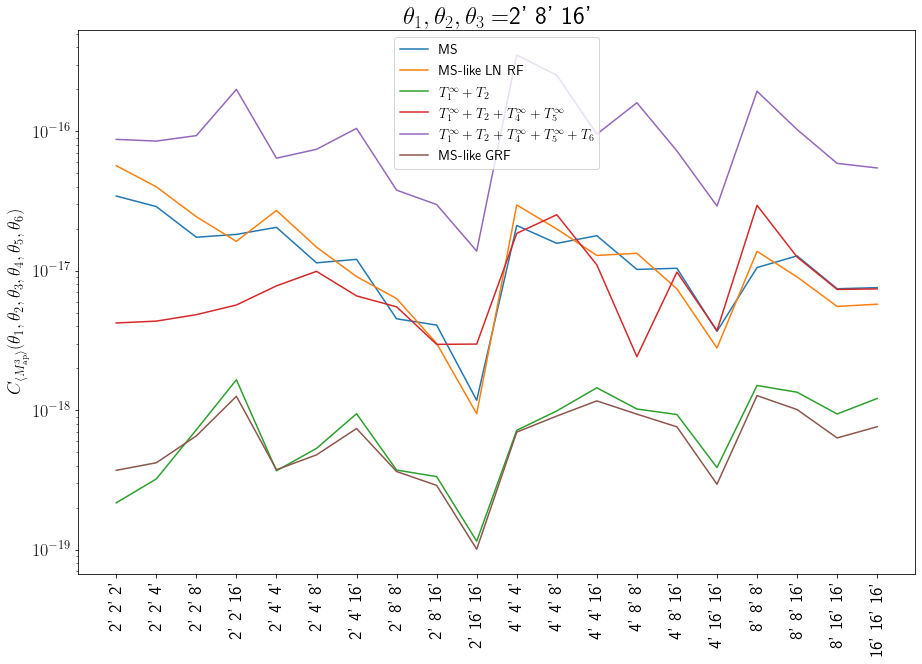

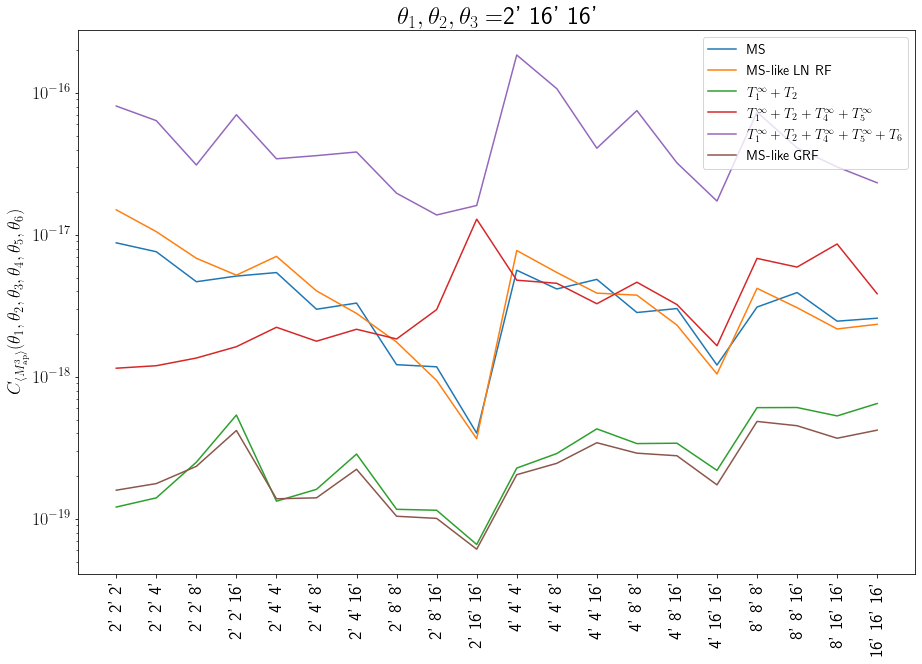

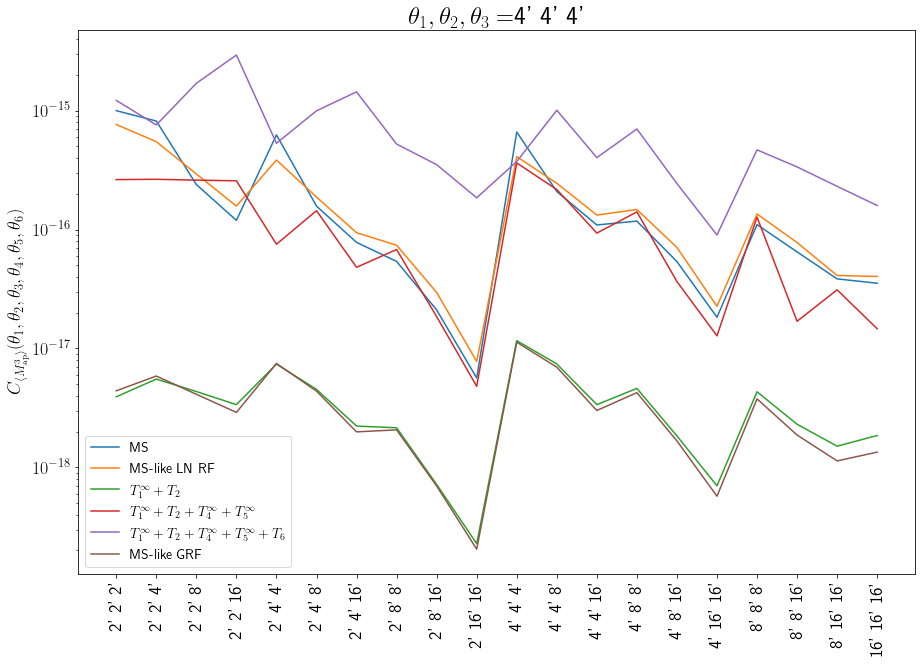

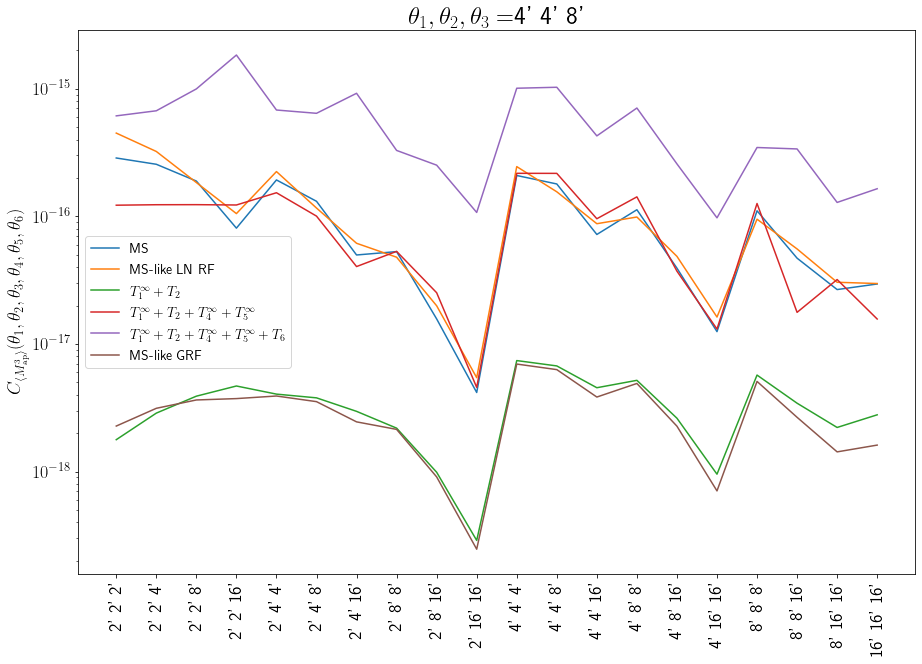

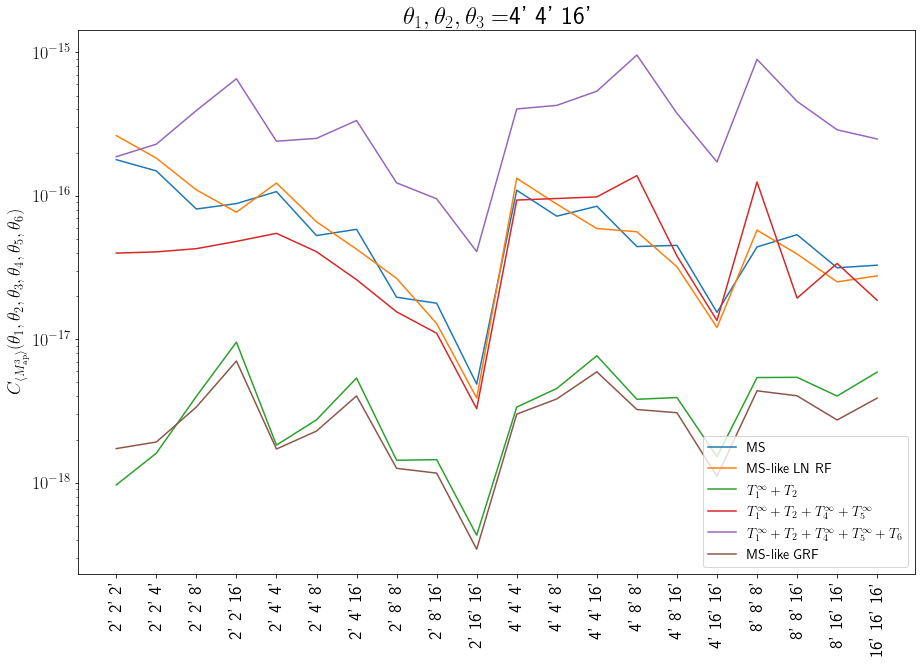

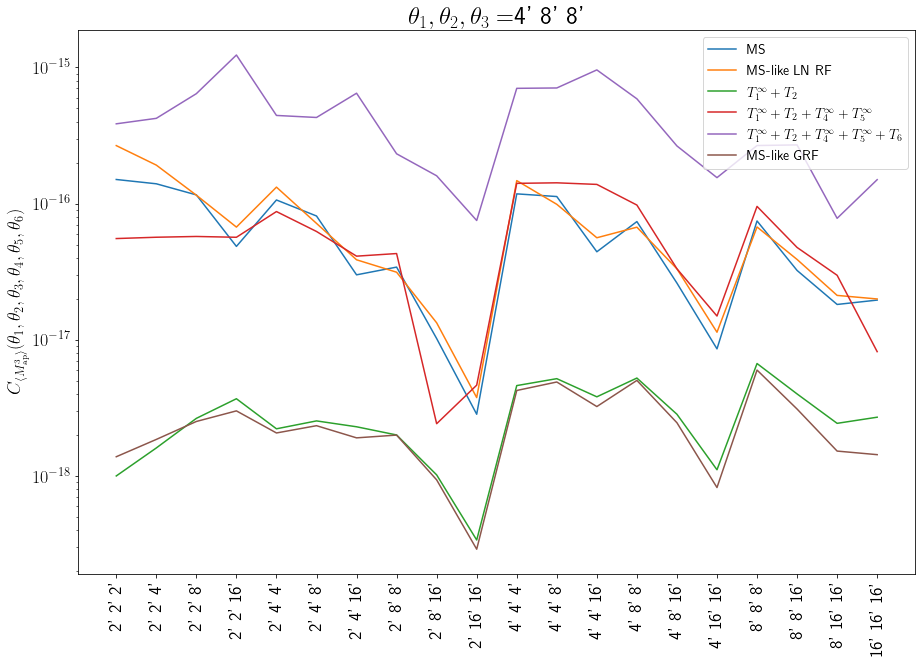

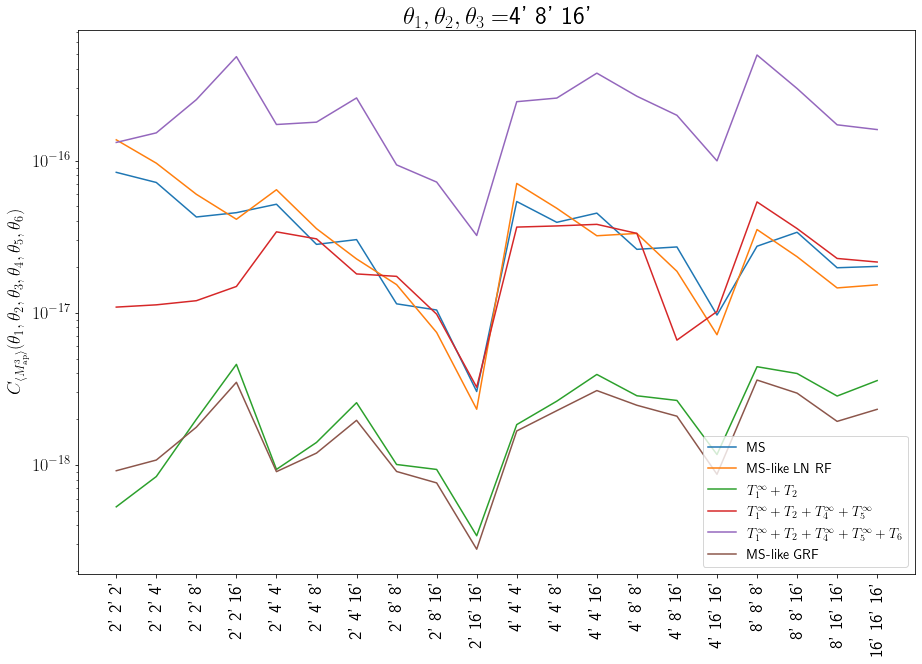

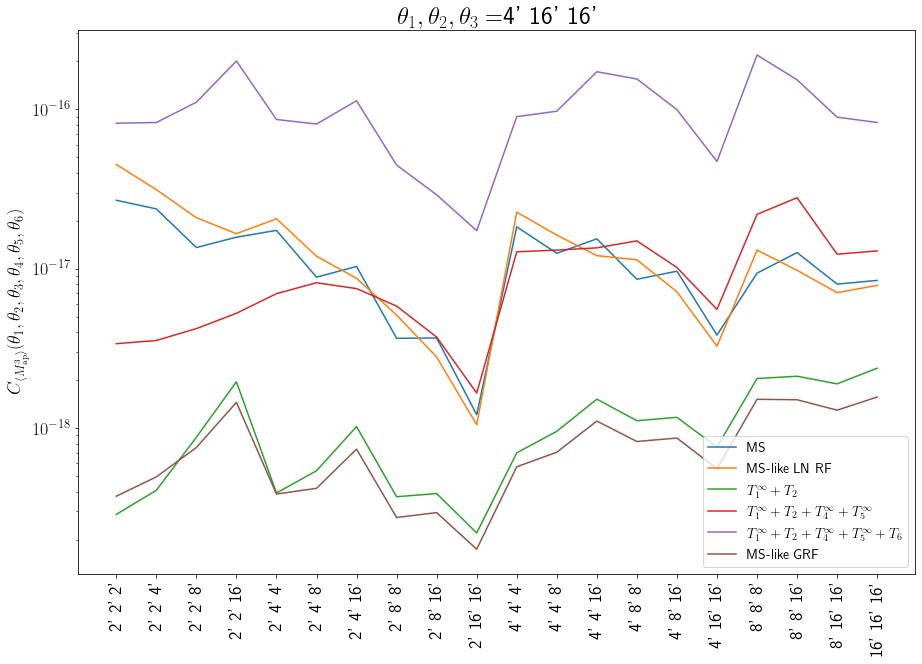

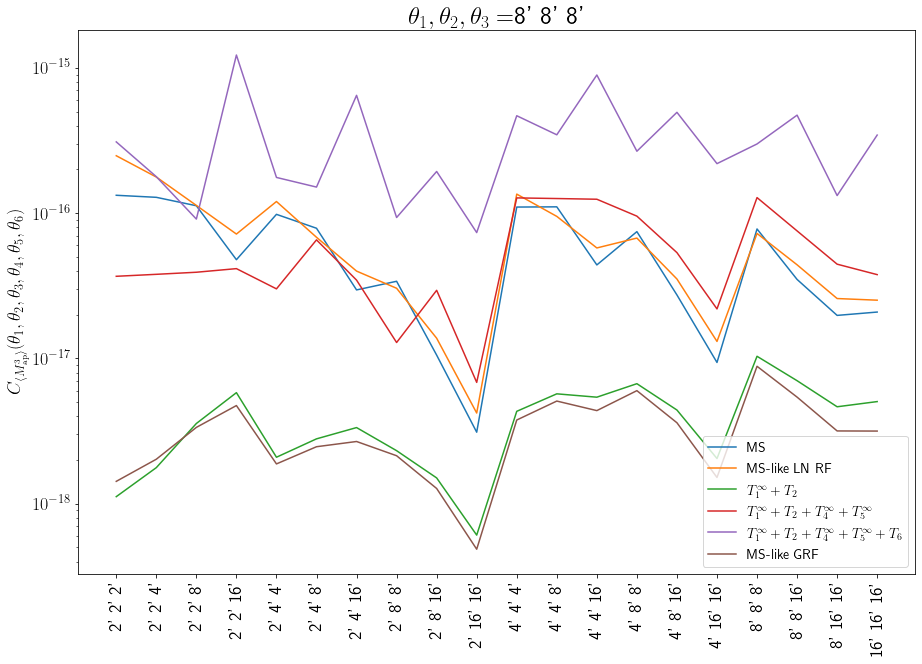

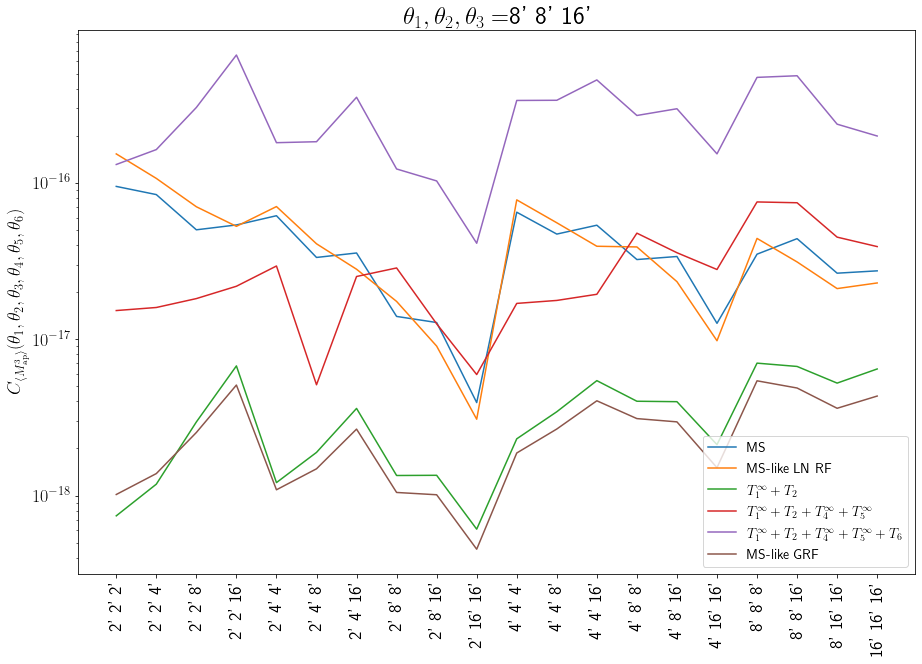

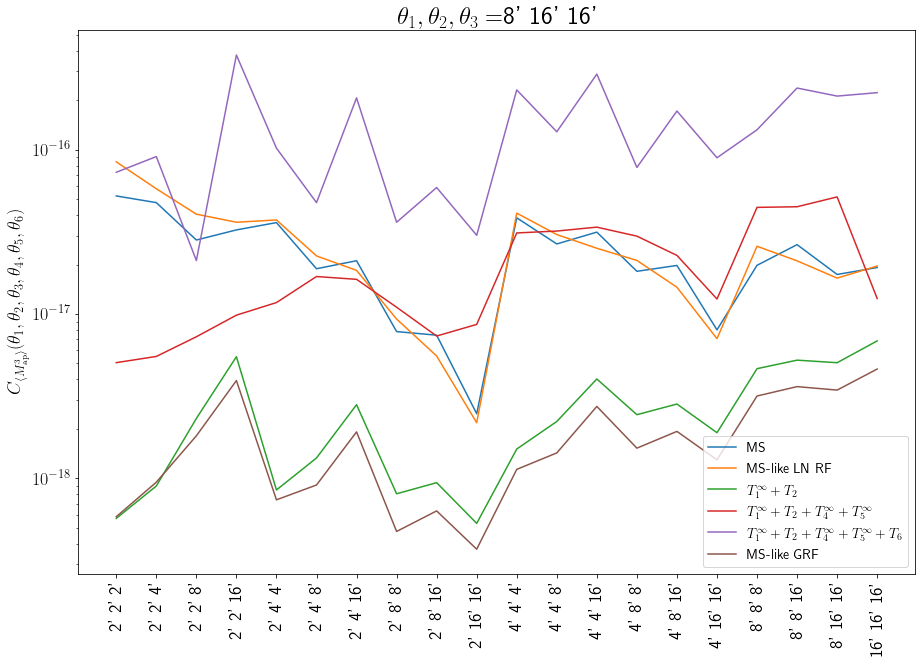

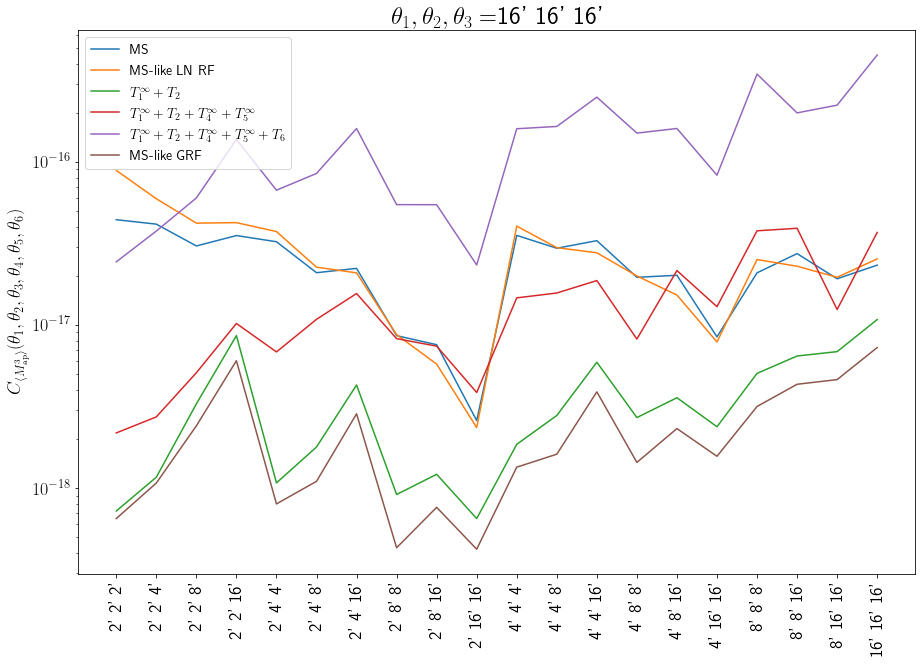

In [10]:
# Line plots

for i in range(20):
    fig, ax=plt.subplots(figsize=(15,10))
    #ax.set_ylim(1e-20, 1e-15)
    ax.set_title(r"$\theta_1, \theta_2, \theta_3=$"+thetas_labels[i], size=25)
    ax.set_yscale('log')
    ax.set_xticks(thetas_ticks)
    ax.set_xticklabels(thetas_labels, rotation=90)
    ax.set_ylabel(r'$C_{\langle M_\mathrm{ap}^3\rangle} (\theta_1, \theta_2, \theta_3, \theta_4, \theta_5, \theta_6)$')
    ax.plot(MScov_fft[i], label='MS')
    ax.plot(MScov_LN[i], label='MS-like LN RF')
#    ax.plot(MScov_LN_cut[i], label='LN, cut')
    ax.plot(MScov_T1inf[i]+MScov_T2[i], label=r'$T_1^\infty+T_2$')
    ax.plot(MScov_T1inf[i]+MScov_T2[i]+MScov_T4[i]+17*MScov_T5[i], label=r'$T_1^\infty+T_2+T_4^\infty+T_5^\infty$')
    ax.plot(MScov_T1inf[i]+MScov_T2[i]+MScov_T4[i]+17*MScov_T5[i]+17*MScov_T6[i], label=r'$T_1^\infty+T_2+T_4^\infty+T_5^\infty+T_6$')
    #ax.plot(MScov_T7[i]*1e6, label=r"$T_7^\infty$")
    #ax.plot(MScov_T1inf[i]+MScov_T2[i]+MScov_T4[i]+6*MScov_T5[i]+6*MScov_T6[i], label=r'$T_1^\infty+T_2+T_4^\infty+6*T_5^\infty+6*T_6$')
    #ax.plot(MScov_T1inf[i]+MScov_T2[i]+MScov_T4[i]+MScov_T5[i]+MScov_T6[i]+MScov_T7[i], label=r'$T_1^\infty+T_2+T_4^\infty+T_5^\infty+T_6+T_7^\infty$')
    ax.plot(MScov_Gauss[i], label='MS-like GRF')
    plt.legend()
    plt.show()

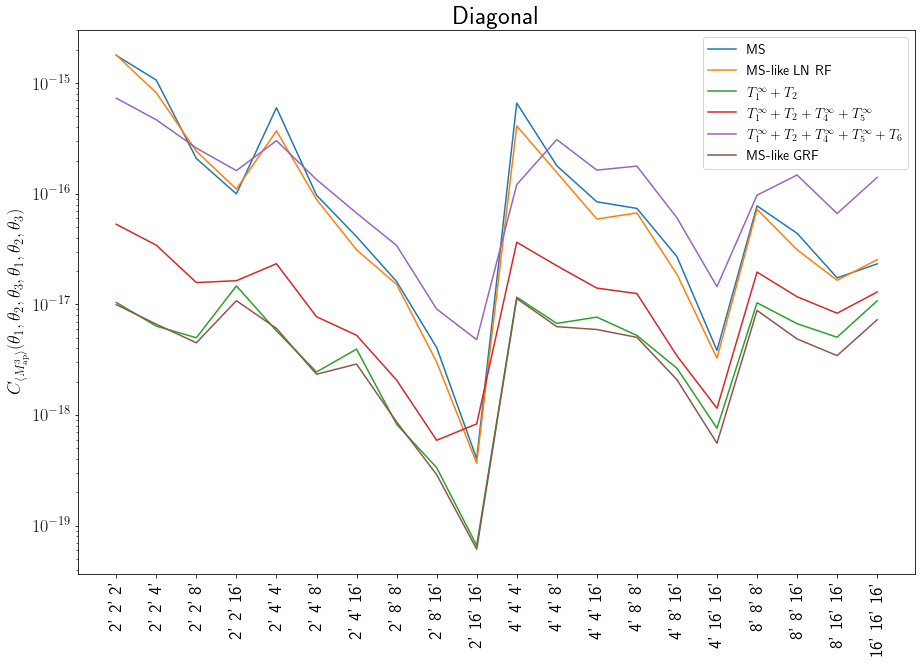

In [14]:
# Line plot Diagonal


fig, ax=plt.subplots(figsize=(15,10))
ax.set_title(r"Diagonal", size=25)
ax.set_yscale('log')
ax.set_xticks(thetas_ticks)
ax.set_xticklabels(thetas_labels, rotation=90)
ax.set_ylabel(r'$C_{\langle M_\mathrm{ap}^3\rangle} (\theta_1, \theta_2, \theta_3, \theta_1, \theta_2, \theta_3)$')
ax.plot(np.diag(MScov_fft), label='MS')
ax.plot(np.diag(MScov_LN), label='MS-like LN RF')
#    ax.plot(MScov_LN_cut[i], label='LN, cut')
ax.plot(np.diag(MScov_T1inf+MScov_T2), label=r'$T_1^\infty+T_2$')
ax.plot(np.diag(MScov_T1inf+MScov_T2+MScov_T4+MScov_T5), label=r'$T_1^\infty+T_2+T_4^\infty+T_5^\infty$')
ax.plot(np.diag(MScov_T1inf+MScov_T2+MScov_T4+MScov_T5+MScov_T6), label=r'$T_1^\infty+T_2+T_4^\infty+T_5^\infty+T_6$')
    #ax.plot(MScov_T1inf[i]+MScov_T2[i]+MScov_T4[i]+6*MScov_T5[i]+6*MScov_T6[i], label=r'$T_1^\infty+T_2+T_4^\infty+6*T_5^\infty+6*T_6$')
    #ax.plot(MScov_T1inf[i]+MScov_T2[i]+MScov_T4[i]+MScov_T5[i]+MScov_T6[i]+MScov_T7[i], label=r'$T_1^\infty+T_2+T_4^\infty+T_5^\infty+T_6+T_7^\infty$')
ax.plot(np.diag(MScov_Gauss), label='MS-like GRF')
plt.legend()
plt.show()

## Comparison with SLICS

### Getting the PDF of SLICS

In [221]:
# Loading data of one LOS
dir_SLICS="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/SLICS_DATA/convergence/"

mean_kappa=[]
std_kappa=[]
skew_kappa=[]
bins=200
Nlos=1100
pdf_kappa=np.zeros((Nlos, bins))
kappa_min, kappa_max=-0.75, 0.75

for los in range(Nlos):

    fn=dir_SLICS+f"kappa_noise_GalCatalog_LOS_cone{los}.fits_s333{los}_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits"
    
    if exists(fn):
        print("Loading", fn)
        kappa= fits.open(fn)[0].data[0]

        print("kappa mean:", np.mean(kappa))
        mean_kappa.append(np.mean(kappa))
        print("kappa std:", np.std(kappa))
        std_kappa.append(np.std(kappa))
        print("kappa skew:", scipy.stats.skew(kappa, axis=None))
        skew_kappa.append(scipy.stats.skew(kappa, axis=None))
        pdf, _tmp=(np.histogram(kappa, bins=bins, density=False, range=(kappa_min, kappa_max)))
    
        pdf_kappa[los]=pdf
   


np.save("SLICS_mean_kappa", mean_kappa)
np.save("SLICS_std_kappa", std_kappa)
np.save("SLICS_skew_kappa", skew_kappa)
np.save("SLICS_pdf_kappa", pdf_kappa)

Loading /home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/SLICS_DATA/convergence/kappa_noise_GalCatalog_LOS_cone74.fits_s33374_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits
kappa mean: 5.320544e-11
kappa std: 0.0866136
kappa skew: 0.013092301785945892
Loading /home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/SLICS_DATA/convergence/kappa_noise_GalCatalog_LOS_cone75.fits_s33375_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits
kappa mean: -4.5474735e-11
kappa std: 0.08678115
kappa skew: 0.013147532939910889
Loading /home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/SLICS_DATA/convergence/kappa_noise_GalCatalog_LOS_cone76.fits_s33376_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits
kappa mean: 3.092282e-11
kappa std: 0.08680404
kappa skew: 0.011036473326385021
Loading /home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/SLICS_DATA/convergence/kappa_noise_GalCatalog_LOS_cone77.fits_s33377_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits
kappa mean: 4.2291504e-11
kappa std

In [222]:
# Get Mean
pdf_xrange=np.linspace(kappa_min, kappa_max, num=bins)
pdf_kappa_mean=np.mean(pdf_kappa, axis=0)
pdf_kappa_std=np.std(pdf_kappa, axis=0)
norm=np.sum(pdf_kappa_mean)*(kappa_max-kappa_min)/bins

In [244]:
# Fit

xdata=pdf_xrange[27:-14]
ydata=pdf_kappa_mean[27:-14]/norm
sigma=pdf_kappa_std[27:-14]/norm/np.sqrt(928)

popt, pcov=curve_fit(lognormal, xdata, ydata, sigma=sigma, absolute_sigma=True, p0=(0.022, 0.66))#, absolute_sigma=False)
popt2, pcov=curve_fit(lognormal, xdata, ydata, p0=(0.022, 0.66))#, absolute_sigma=False)


Text(0.5, 0, '$\\kappa$')

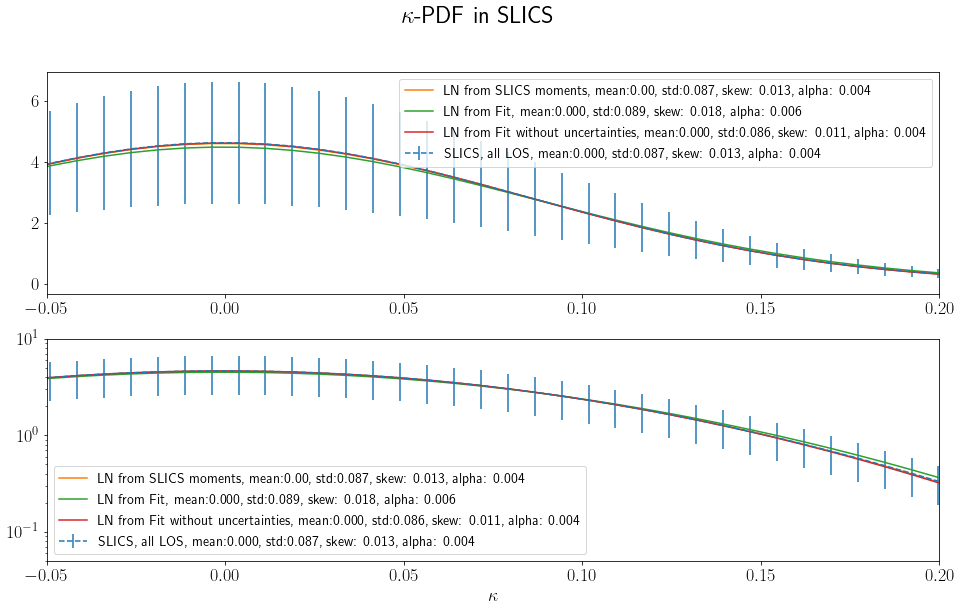

In [245]:
# Get the parameters of the pdfs

SLICS_mean=np.mean(mean_kappa)
SLICS_std=np.mean(std_kappa)
SLICS_skew=np.mean(skew_kappa)
SLICS_alpha=skew2alpha(SLICS_skew)
SLICS_kappa0=alpha_std2kappa0(SLICS_alpha, SLICS_std)

Hilbert_mean=0
Hilbert_alpha=0.66
Hilbert_skew=alpha2skew(Hilbert_alpha)
Hilbert_kappa0=0.0291
Hilbert_std=kappa0_alpha2std(Hilbert_kappa0, Hilbert_alpha)

fit_mean=0
fit_alpha=popt[1]
fit_skew=alpha2skew(fit_alpha)
fit_kappa0=popt[0]
fit_std=kappa0_alpha2std(fit_kappa0, fit_alpha)

fit_mean_unweighted=0
fit_alpha_unweighted=popt2[1]
fit_skew_unweighted=alpha2skew(fit_alpha_unweighted)
fit_kappa0_unweighted=popt2[0]
fit_std_unweighted=kappa0_alpha2std(fit_kappa0_unweighted, fit_alpha_unweighted)

# Do the plots
fig, ax=plt.subplots(figsize=(16,9), nrows=2)
fig.suptitle(r"$\kappa$-PDF in SLICS")
ax[0].set_xlim((-0.05, 0.2))
ax[0].errorbar(pdf_xrange, pdf_kappa_mean/norm, yerr=pdf_kappa_std/norm, label=f'SLICS, all LOS, mean:{SLICS_mean:.3f}, std:{SLICS_std:.3f}, skew: {SLICS_skew:.3f}, alpha: {SLICS_alpha:.3f}', ls='--')
ax[0].plot(pdf_xrange, lognormal(pdf_xrange, SLICS_kappa0, SLICS_alpha), label=f'LN from SLICS moments, mean:{SLICS_mean:.2f}, std:{SLICS_std:.3f}, skew: {SLICS_skew:.3f}, alpha: {SLICS_alpha:.3f}')
#ax[0].plot(pdf_xrange, lognormal(pdf_xrange, Hilbert_kappa0, Hilbert_alpha), label=f'LN from Hilbert+ (2011), mean:{Hilbert_mean:.3f}, std:{Hilbert_std:.3f}, skew: {Hilbert_skew:.3f}, alpha: {Hilbert_alpha:.3f}')
ax[0].plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0, fit_alpha), label=f'LN from Fit, mean:{fit_mean:.3f}, std:{fit_std:.3f}, skew: {fit_skew:.3f}, alpha: {fit_alpha:.3f}')
ax[0].plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0_unweighted, fit_alpha_unweighted), label=f'LN from Fit without uncertainties, mean:{fit_mean_unweighted:.3f}, std:{fit_std_unweighted:.3f}, skew: {fit_skew_unweighted:.3f}, alpha: {fit_alpha_unweighted:.3f}')
ax[0].legend()

ax[1].set_xlim((-0.05, 0.2))
ax[1].set_yscale('log')
ax[1].set_ylim((5e-2, 10))
ax[1].errorbar(pdf_xrange, pdf_kappa_mean/norm, yerr=pdf_kappa_std/norm, label=f'SLICS, all LOS, mean:{SLICS_mean:.3f}, std:{SLICS_std:.3f}, skew: {SLICS_skew:.3f}, alpha: {SLICS_alpha:.3f}', ls='--')
ax[1].plot(pdf_xrange, lognormal(pdf_xrange, SLICS_kappa0, SLICS_alpha), label=f'LN from SLICS moments, mean:{SLICS_mean:.2f}, std:{SLICS_std:.3f}, skew: {SLICS_skew:.3f}, alpha: {SLICS_alpha:.3f}')
#ax[1].plot(pdf_xrange, lognormal(pdf_xrange, Hilbert_kappa0, Hilbert_alpha), label=f'LN from Hilbert+ (2011), mean:{Hilbert_mean:.3f}, std:{Hilbert_std:.3f}, skew: {Hilbert_skew:.3f}, alpha: {Hilbert_alpha:.3f}')
ax[1].plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0, fit_alpha), label=f'LN from Fit, mean:{fit_mean:.3f}, std:{fit_std:.3f}, skew: {fit_skew:.3f}, alpha: {fit_alpha:.3f}')
ax[1].plot(pdf_xrange, lognormal(pdf_xrange, fit_kappa0_unweighted, fit_alpha_unweighted), label=f'LN from Fit without uncertainties, mean:{fit_mean_unweighted:.3f}, std:{fit_std_unweighted:.3f}, skew: {fit_skew_unweighted:.3f}, alpha: {fit_alpha_unweighted:.3f}')
ax[1].legend()
ax[1].set_xlabel(r'$\kappa$')

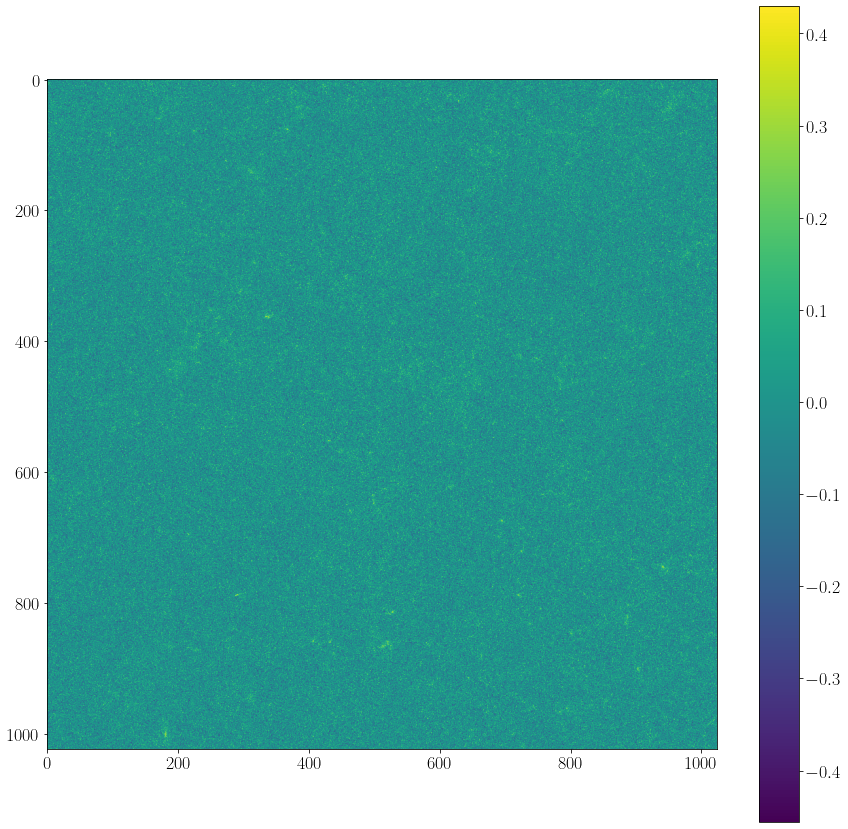

In [35]:
# Load SLICS LOS
from astropy.io import fits

slics_kappa = fits.open(filename)[0].data[0]

plt.figure(figsize=(15,15))
plt.imshow(slics_kappa)
plt.colorbar()

<ipython-input-36-52273f9fe045>:5: RuntimeWarning: invalid value encountered in log
  p=np.log(x/A+1)+0.5*alpha*alpha
<ipython-input-36-52273f9fe045>:5: RuntimeWarning: invalid value encountered in log
  p=np.log(x/A+1)+0.5*alpha*alpha


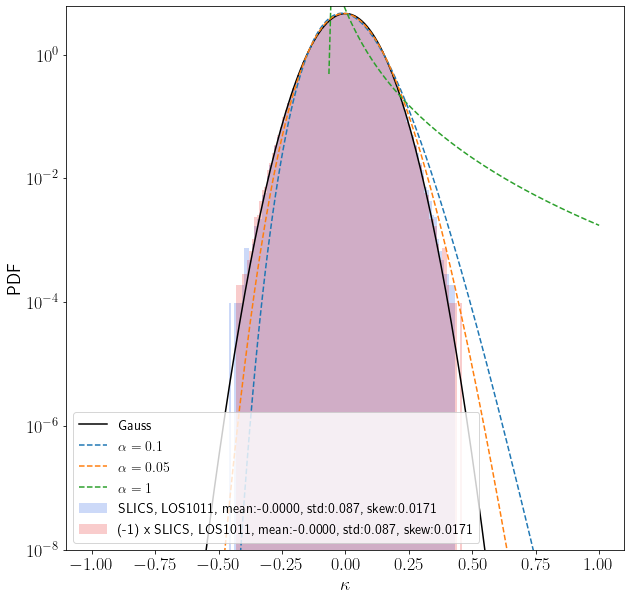

In [38]:
# Plot PDF of SLICS

mean_slics=np.mean(slics_kappa.ravel())
std_slics=np.std(slics_kappa.ravel())

skew_slics=scipy.stats.skew(slics_kappa.ravel())


fig, ax=plt.subplots(figsize=(10,10))

ax.hist(slics_kappa.ravel(), bins=200, density=True, range=(-1, 1), color='xkcd:blue', label=f'SLICS, LOS1011, mean:{mean_slics:.4f}, std:{std_slics:.3f}, skew:{skew_slics:.4f}', alpha=0.2)
ax.hist(-slics_kappa.ravel(), bins=200, density=True, range=(-1, 1), color='xkcd:red', label=f'(-1) x SLICS, LOS1011, mean:{mean_slics:.4f}, std:{std_slics:.3f}, skew:{skew_slics:.4f}', alpha=0.2)
x=np.linspace(-1, 1, num=200)

sigma=0.087
plt.ylim(1e-8, 6)
plt.yscale('log')
ax.plot(x, gauss(x, sigma=sigma), label=r"Gauss", ls='-', color='k')
ax.plot(x,lognormal(x, alpha=0.1, sigma=sigma), label=r"$\alpha=0.1$", ls='--')
#ax.plot(x,lognormal(x, alpha=0.5, sigma=sigma), label=r"$\alpha=0.5$")
ax.plot(x,lognormal(x, alpha=0.05, sigma=sigma), label=r"$\alpha=0.05$", ls='--')
ax.plot(x,lognormal(x, alpha=1, sigma=sigma), label=r"$\alpha=1$", ls='--')
#ax.plot(x,lognormal(x, alpha=2, sigma=sigma), label=r"$\alpha=2$", ls='--')
ax.set_xlabel(r"$\kappa$")
ax.set_ylabel(r"PDF")

plt.legend()

### Plot Covariance of SLICS compared to Gaussian with different Shape noises

(4, 4, 4, 1, 128)


<ErrorbarContainer object of 3 artists>

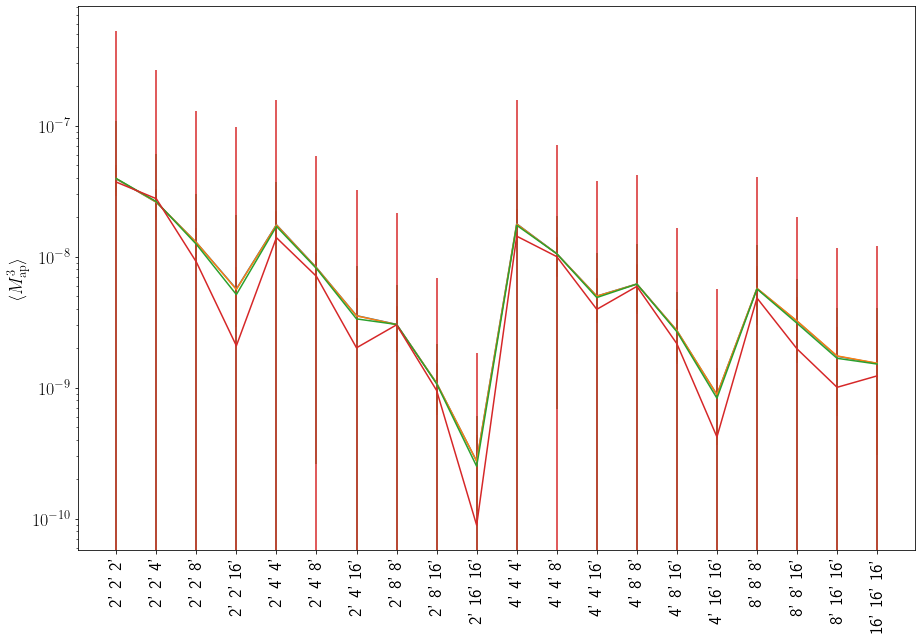

In [57]:
# Read in Map3 from SLICS
dir_slics="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS/"
dir_slics_05="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS_sn0_5/"
dir_slics_10="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS_sn1_0/"
dir_slics_20="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/SLICS_sn2_0/"

dir_slics_grf="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/GaussianRandomFields_slicslike/"
dir_slics_grf_05="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/GaussianRandomFields_slicslike_sn0_5/"
dir_slics_grf_10="/home/laila/OneDrive/1_Work/5_Projects/02_3ptStatistics/Map3_Covariances/GaussianRandomFields_slicslike_sn1_0/"

Map3slics=np.loadtxt(dir_slics+"map_cubed").T
Map3slics_mean=np.mean(Map3slics, axis=1)
Map3slics_std=np.std(Map3slics, axis=1)

Map3slics_05=np.loadtxt(dir_slics_05+"map_cubed").T
Map3slics_mean_05=np.mean(Map3slics_05, axis=1)
Map3slics_std_05=np.std(Map3slics_05, axis=1)

Map3slics_10=np.loadtxt(dir_slics_10+"map_cubed").T
Map3slics_mean_10=np.mean(Map3slics_10, axis=1)
Map3slics_std_10=np.std(Map3slics_10, axis=1)

Map3slics_20=np.loadtxt(dir_slics_20+"map_cubed").T
Map3slics_mean_20=np.mean(Map3slics_20, axis=1)
Map3slics_std_20=np.std(Map3slics_20, axis=1)


Map3slics_gauss=np.load(dir_slics_grf+"map_cubed_from_gamma_npix_4096_fieldsize_10.npy")[:,:,:,:,:Nlos]
print(Map3slics_gauss.shape)
Map3slics_gauss = Map3slics_gauss.reshape(N*N*N, Nlos)
Map3slics_gauss = Map3slics_gauss[ixs].T

Map3slics_gauss_05 =np.load(dir_slics_grf_05+"map_cubed_from_gamma_npix_4096_fieldsize_10.npy")
Map3slics_gauss_05 = Map3slics_gauss_05.reshape(N*N*N, Nlos)
Map3slics_gauss_05 = Map3slics_gauss_05[ixs].T

Map3slics_gauss_10 =np.load(dir_slics_grf_10+"map_cubed_from_gamma_npix_4096_fieldsize_10.npy")
Map3slics_gauss_10 = Map3slics_gauss_10.reshape(N*N*N, Nlos)
Map3slics_gauss_10 = Map3slics_gauss_10[ixs].T


fig, ax=plt.subplots(figsize=(15,10))
ax.set_yscale('log')
ax.set_xticks(thetas_ticks)
ax.set_xticklabels(thetas_labels, rotation=90)
ax.set_ylabel(r'$\langle M_\mathrm{ap}^3\rangle$')
ax.errorbar(range(20), Map3slics_mean, yerr=Map3slics_std, label='SLICS')
ax.errorbar(range(20), Map3slics_mean_05, yerr=Map3slics_std_05, label=r'SLICS + $\sigma=0.5$')
ax.errorbar(range(20), Map3slics_mean_10, yerr=Map3slics_std_10, label=r'SLICS + $\sigma=1.0$')
ax.errorbar(range(20), Map3slics_mean_20, yerr=Map3slics_std_20, label=r'SLICS + $\sigma=2.0$')

In [58]:
# Calculate covariance and read in analytic cov

SLICScov=np.cov(Map3slics)
SLICScov_05=np.cov(Map3slics_05)
SLICScov_10=np.cov(Map3slics_10)
SLICScov_20=np.cov(Map3slics_20)

SLICScov_T1inf=np.loadtxt(dir_slics+"cov_infinite_term1Numerical_sigma_0.37_n_107987.71_thetaMax_7.87_gpu.dat")
SLICScov_T2=np.loadtxt(dir_slics+"cov_square_term2Numerical_sigma_0.37_n_107987.71_thetaMax_7.87_gpu.dat")

SLICScov_T1inf_05=np.loadtxt(dir_slics_05+"cov_infinite_term1Numerical_sigma_0.87_n_107987.71_thetaMax_7.87_gpu.dat")
SLICScov_T2_05=np.loadtxt(dir_slics_05+"cov_square_term2Numerical_sigma_0.87_n_107987.71_thetaMax_7.87_gpu.dat")

SLICScov_T1inf_10=np.loadtxt(dir_slics_10+"cov_infinite_term1Numerical_sigma_1.37_n_107987.71_thetaMax_7.87_gpu.dat")
SLICScov_T2_10=np.loadtxt(dir_slics_10+"cov_square_term2Numerical_sigma_1.37_n_107987.71_thetaMax_7.87_gpu.dat")

SLICScov_grf=np.cov(Map3slics_gauss.T)
SLICScov_grf_05=np.cov(Map3slics_gauss_05.T)
SLICScov_grf_10=np.cov(Map3slics_gauss_10.T)


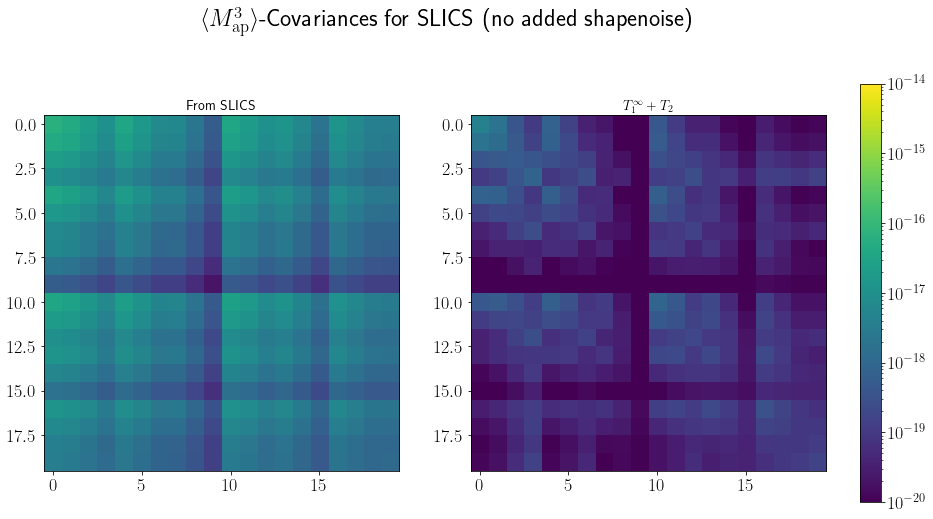

In [101]:
# Plot SLICS 

fig, ax=plt.subplots(figsize=(15,10), ncols=2)
fig.suptitle(r"$\langle M_\mathrm{ap}^3\rangle$-Covariances for SLICS (no added shapenoise)", y=0.9)
ax[0].set_title("From SLICS")
im=ax[0].imshow(SLICScov, norm=LogNorm(vmin=1e-20, vmax=1e-14))
ax[1].set_title(r"$T_1^\infty + T_2$")
im=ax[1].imshow(SLICScov_T1inf+SLICScov_T2, norm=LogNorm(vmin=1e-20, vmax=1e-14))
#ax[2].set_title("From GRF")
#im=ax[2].imshow(SLICScov_grf, norm=LogNorm(vmin=1e-23, vmax=1e-16))
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.025, pad=0.04)


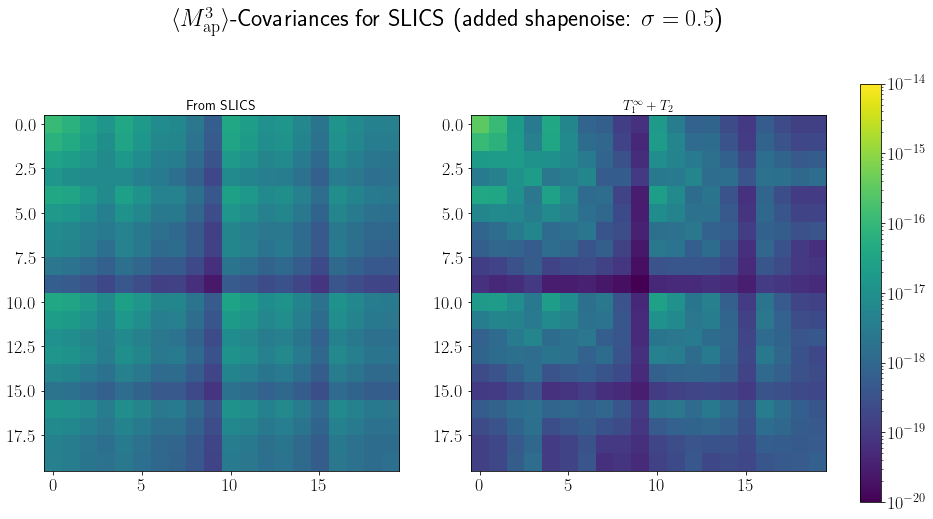

In [102]:
# Plot SLICS 

fig, ax=plt.subplots(figsize=(15,10), ncols=2)
fig.suptitle(r"$\langle M_\mathrm{ap}^3\rangle$-Covariances for SLICS (added shapenoise: $\sigma=0.5$)", y=0.9)
ax[0].set_title("From SLICS")
im=ax[0].imshow(SLICScov_05, norm=LogNorm(vmin=1e-20, vmax=1e-14))
ax[1].set_title(r"$T_1^\infty + T_2$")
im=ax[1].imshow(SLICScov_T1inf_05+SLICScov_T2_05, norm=LogNorm(vmin=1e-20, vmax=1e-14))
#ax[2].set_title("From GRF")
#im=ax[2].imshow(SLICScov_grf_05, norm=LogNorm(vmin=1e-23, vmax=1e-16))
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.025, pad=0.04)

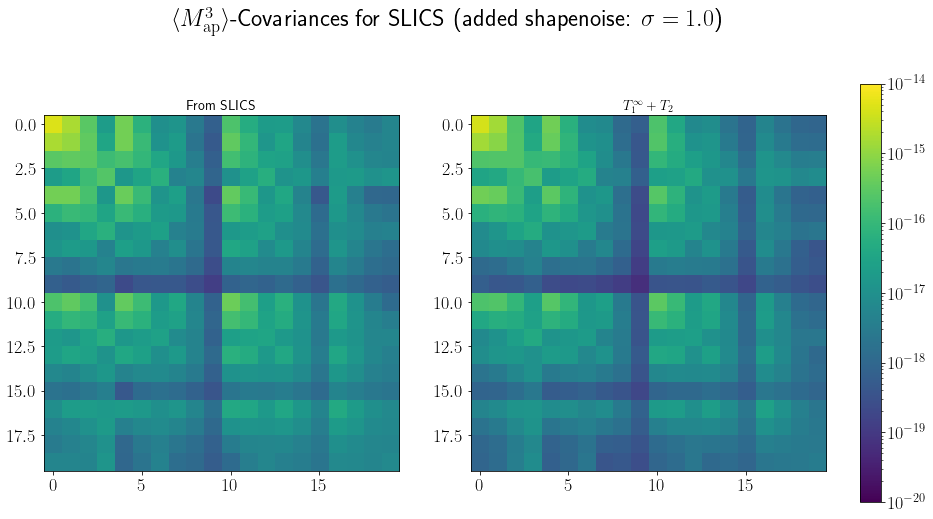

In [103]:
# Plot SLICS 

fig, ax=plt.subplots(figsize=(15,10), ncols=2)
fig.suptitle(r"$\langle M_\mathrm{ap}^3\rangle$-Covariances for SLICS (added shapenoise: $\sigma=1.0$)", y=0.9)
ax[0].set_title("From SLICS")
im=ax[0].imshow(SLICScov_10, norm=LogNorm(vmin=1e-20, vmax=1e-14))
ax[1].set_title(r"$T_1^\infty + T_2$")
im=ax[1].imshow(SLICScov_T1inf_10+SLICScov_T2_10, norm=LogNorm(vmin=1e-20, vmax=1e-14))
#ax[2].set_title("From GRF")
#im=ax[2].imshow(SLICScov_grf_10, norm=LogNorm(vmin=1e-20, vmax=1e-14))
fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.025, pad=0.04)